In [30]:
import sys
sys.path.insert(0, '..')
%matplotlib inline
from IPython import display
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
from mxnet.gluon import data as gdata
import sys
import time
from mxnet import gluon, init, autograd
from mxnet.gluon import loss as gloss, nn
import mxnet as mx
import numpy as np

In [31]:
mnist_train = gdata.vision.MNIST(train=True)
mnist_test = gdata.vision.MNIST(train=False)
len(mnist_train), len(mnist_test)

(60000, 10000)

In [32]:
feature, label = mnist_train[0]
feature.shape, feature.dtype

((28, 28, 1), numpy.uint8)

In [33]:
label, type(label), label.dtype

(5, numpy.int32, dtype('int32'))

In [34]:
def get_mnist_labels(labels):
   text_labels = ['zero', 'one', 'two', 'three', 'four',
   'five', 'six', 'seven', 'eight', 'nine']
   return [text_labels[int(i)] for i in labels]

In [35]:
def show_mnist(images, labels):
   display.set_matplotlib_formats('svg')
   # Here _ means that we ignore (not use) variables
   _, figs = plt.subplots(1, len(images), figsize=(12, 12))
   for f, img, lbl in zip(figs, images, labels):
       f.imshow(img.reshape((28, 28)).asnumpy())
       f.set_title(lbl)
       f.axes.get_xaxis().set_visible(False)
       f.axes.get_yaxis().set_visible(False)

In [36]:
X, y = mnist_train[0:9]
# show_mnist(X, get_mnist_labels(y))

In [37]:
batch_size = 256
transformer = gdata.vision.transforms.ToTensor()
if sys.platform.startswith('win'):
   # 0 means no additional processes are needed to speed up the reading of
   # data
   num_workers = 0
else:
   num_workers = 4

train_iter = gdata.DataLoader(mnist_train.transform_first(transformer),
   batch_size, shuffle=True,
   num_workers=num_workers)
test_iter = gdata.DataLoader(mnist_test.transform_first(transformer),
   batch_size, shuffle=False,
   num_workers=num_workers)

In [38]:
start = time.time()
for X, y in train_iter:
   continue
'%.2f sec' % (time.time() - start)

'1.19 sec'

In [44]:
#Initialize the Model
def init(net, optimizer='sgd', learning_rate=0.1, weight_decay=1e-6, ctx=mx.cpu()):
   net.collect_params().initialize(mx.init.Xavier(magnitude=2.24), ctx=ctx)
   trainer = gluon.Trainer(net.collect_params(),
                           optimizer,
                           {'learning_rate': learning_rate, 'wd': weight_decay})
   return trainer

In [45]:
# Computing Accuracy
def accuracy(data_iterator, net,ctx=mx.cpu()):
  acc = mx.metric.Accuracy()
  for (data, label) in data_iterator:
      data = data.as_in_context(ctx)
      label = label.as_in_context(ctx)
      output = net(data)
      predictions = mx.nd.argmax(output, axis=1)
      acc.update(preds=predictions, labels=label)
  return acc.get()[1]


In [46]:
#Training the Model
def train(net, trainer, train_data, validation_data, epochs, ctx=mx.cpu()):
   training_accuracies = []
   validation_accuracies = []
   softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()
   for e in range(epochs):
       tic = time.time()
       for (data, label) in train_data:
           data  = data.as_in_context(ctx)
           label = label.as_in_context(ctx)
           with autograd.record():
               output = net(data)
               loss = softmax_cross_entropy(output, label)
               loss.backward()
           trainer.step(data.shape[0])
       toc = time.time()
       train_accuracy = accuracy(train_data, net)
       training_accuracies.append(train_accuracy)
       validation_accuracy = accuracy(validation_data, net)
       validation_accuracies.append(validation_accuracy)
       print("Epoch#%d Time=%.2f Training=%.4f Validation=%.4f Diff=%.4f"
             % (e, toc-tic, train_accuracy, validation_accuracy, train_accuracy-validation_accuracy))
   return training_accuracies, validation_accuracies

In [47]:
def plot_accuracies(training_accuracies, validation_accuracies):
   epochs = len(training_accuracies)
   plt.clf()
   fig, ax = plt.subplots()
   plt.xlabel('Epochs')
   plt.ylabel('Accuracy')
   train_plot, = ax.plot(range(epochs), training_accuracies, label="Training accuracy")
   validation_plot, = ax.plot(range(epochs), validation_accuracies, label="Validation accuracy")
   plt.legend(handles=[train_plot,validation_plot])
   plt.xticks(np.arange(0, epochs, 5))
   ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.4f'))
   plt.show()

Epoch#0 Time=1.31 Training=0.9083 Validation=0.9125 Diff=-0.0042
Epoch#1 Time=1.22 Training=0.9307 Validation=0.9321 Diff=-0.0014
Epoch#2 Time=1.27 Training=0.9403 Validation=0.9378 Diff=0.0025
Epoch#3 Time=1.21 Training=0.9539 Validation=0.9517 Diff=0.0022
Epoch#4 Time=1.29 Training=0.9567 Validation=0.9522 Diff=0.0045
Epoch#5 Time=1.16 Training=0.9645 Validation=0.9602 Diff=0.0043
Epoch#6 Time=1.36 Training=0.9648 Validation=0.9598 Diff=0.0050
Epoch#7 Time=1.36 Training=0.9735 Validation=0.9669 Diff=0.0066
Epoch#8 Time=1.25 Training=0.9753 Validation=0.9678 Diff=0.0075
Epoch#9 Time=1.29 Training=0.9785 Validation=0.9707 Diff=0.0078
Epoch#10 Time=1.25 Training=0.9800 Validation=0.9727 Diff=0.0073
Epoch#11 Time=1.33 Training=0.9812 Validation=0.9723 Diff=0.0089
Epoch#12 Time=1.34 Training=0.9845 Validation=0.9732 Diff=0.0113
Epoch#13 Time=1.30 Training=0.9853 Validation=0.9757 Diff=0.0096
Epoch#14 Time=1.37 Training=0.9850 Validation=0.9740 Diff=0.0110
Epoch#15 Time=1.28 Training=0.987

<Figure size 432x288 with 0 Axes>

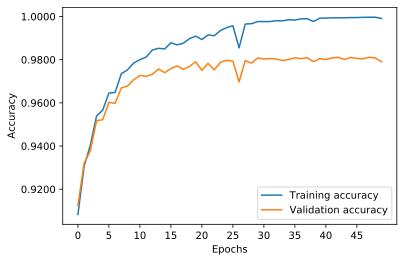

In [54]:
net = nn.Sequential()
net.add(nn.Dense(256, activation='relu'))
net.add(nn.Dense(256, activation='tanh'))
net.add(nn.Dense(10))
trainer = init(net)
training_accuracies, validation_accuracies = train(net, trainer, train_iter, test_iter, 50)
plot_accuracies(training_accuracies, validation_accuracies)
